In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

from hawkes.hawkes.hawkes_tpp import ExpKernelHawkesProcess


In [2]:
model_path = Path("./models/new_hawkes.pth")

state_dict = torch.load(model_path, torch.device("cpu"))

model = ExpKernelHawkesProcess(D=1268)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [3]:
mu, alpha, beta = model.transform_params()

Text(0.5, 1.0, '$Log_10 Decay Rate (Intensity)')

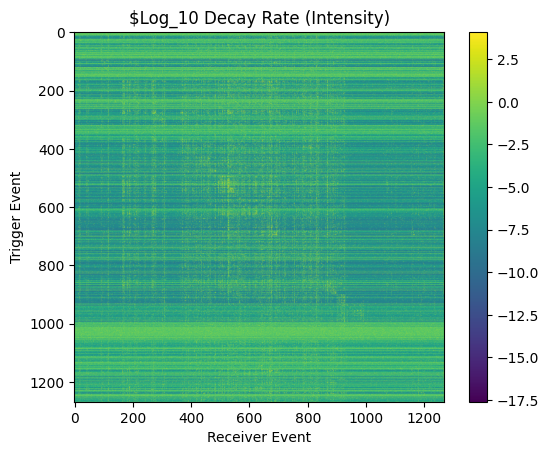

In [4]:
plt.imshow(torch.log(beta.T).detach().numpy())
plt.xlabel("Receiver Event")
plt.ylabel("Trigger Event")
plt.colorbar()
plt.title("$Log_10 Decay Rate (Intensity)")

Text(0.5, 1.0, '$Log_10 Amplitude (Intensity)')

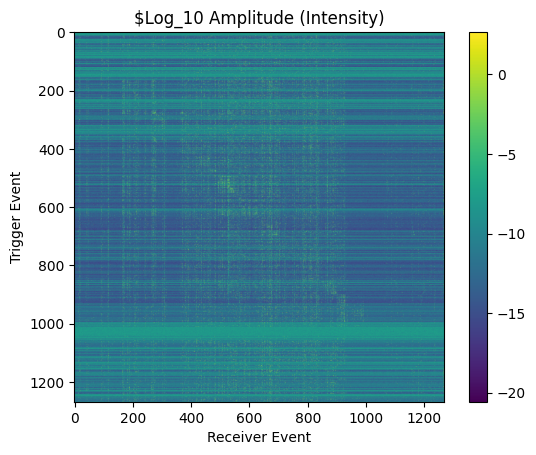

In [5]:
plt.imshow(torch.log(alpha.T).detach().numpy())
plt.xlabel("Receiver Event")
plt.ylabel("Trigger Event")
plt.colorbar()
plt.title("$Log_10 Amplitude (Intensity)")

In [6]:
realistic_influence = alpha * 1 - torch.exp(-beta * 1.0)
realistic_influence

tensor([[-0.7430, -0.0089, -0.3959,  ..., -0.9146, -0.9980, -0.0126],
        [-0.4771, -0.8528, -0.8386,  ..., -0.9560, -0.9989, -0.8086],
        [-0.8040, -0.2748, -0.3106,  ..., -0.9961, -0.9987, -0.8617],
        ...,
        [-0.8042, -0.8607, -0.8207,  ..., -0.9923, -0.9976, -0.8986],
        [-0.8459, -0.8287, -0.7886,  ..., -0.9214, -0.9975, -0.0037],
        [-0.8042, -0.8790, -0.8876,  ...,  0.2648, -0.6585, -0.4863]],
       grad_fn=<SubBackward0>)

Text(0.5, 0, 'Receiver Event')

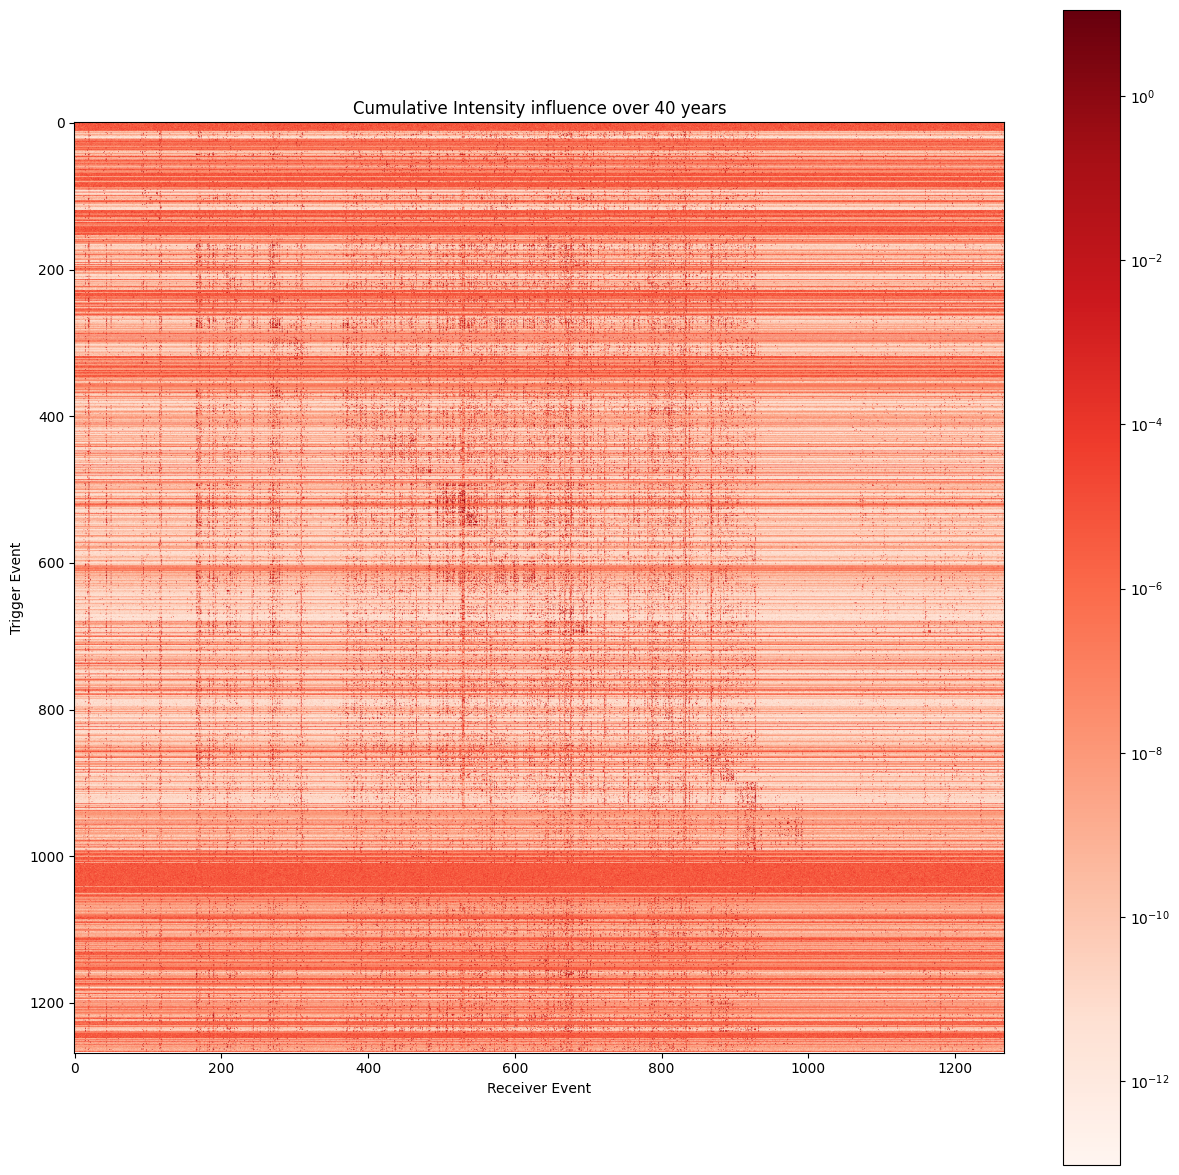

In [11]:
bb = alpha.T.detach().numpy() * (1 - torch.exp(-beta.T * 5 / 80).detach().numpy())
plt.figure(figsize=(15, 15), dpi=100)
plt.imshow(bb, cmap="Reds", norm="log")
plt.colorbar()
plt.title("Cumulative Intensity influence over 40 years")
plt.ylabel("Trigger Event")
plt.xlabel("Receiver Event")

In [ ]:
import matplotlib.patches as mpatches

# Hawkes Process Influence Visualization

We'll create several visualizations to understand the influence structure:
1. **Influence Network Graph** - showing strongest connections between event types
2. **Intensity Evolution** - simulating and showing how intensity changes over time
3. **Top Influencers** - identifying most influential event type pairs

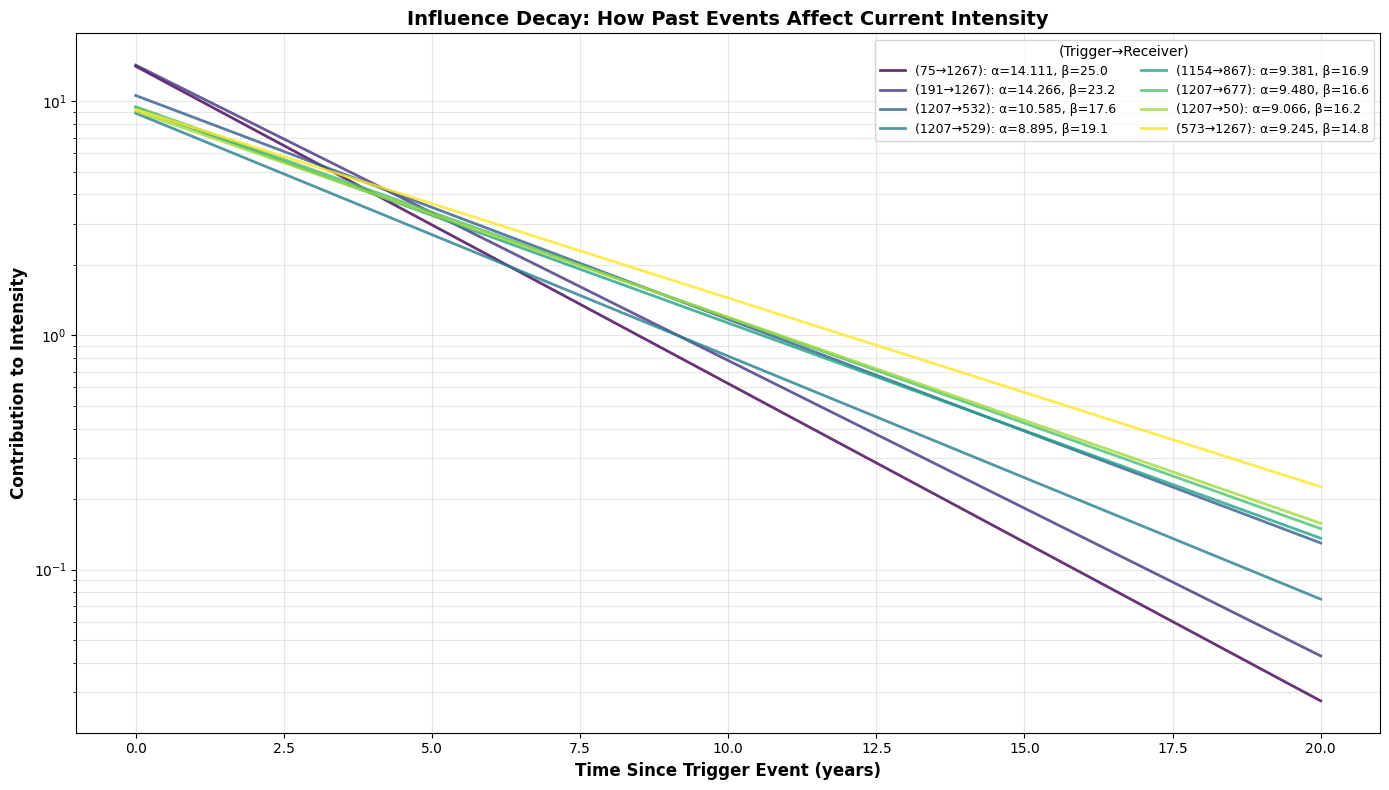

In [ ]:
def plot_influence_decay(alpha, beta, n_pairs=10):
    """
    Plot how influence decays over time for top event pairs.
    """
    # Get top pairs
    D = alpha.shape[0]
    influence_1yr = alpha * (1 - torch.exp(-beta * (1 / 80)))

    inf_flat = influence_1yr.flatten()
    top_indices = torch.argsort(inf_flat, descending=True)

    # Time grid
    t_grid = torch.linspace(0, 20 / 80, 200)  # 0 to 20 years

    fig, ax = plt.subplots(figsize=(14, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, n_pairs))

    for idx, flat_idx in enumerate(top_indices[:n_pairs]):
        i = flat_idx // D  # receiver
        j = flat_idx % D  # trigger

        a = alpha[i, j]
        b = beta[i, j]

        # Exponential kernel: α * exp(-β * t)
        intensity_contrib = a * torch.exp(-b * t_grid)

        label = f"({j.item()}→{i.item()}): α={a.item():.3f}, β={b.item():.1f}"
        ax.plot(
            t_grid.detach().numpy() * 80,
            intensity_contrib.detach().numpy(),
            linewidth=2,
            color=colors[idx],
            label=label,
            alpha=0.8,
        )

    ax.set_xlabel("Time Since Trigger Event (years)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Contribution to Intensity", fontsize=12, fontweight="bold")
    ax.set_title("Influence Decay: How Past Events Affect Current Intensity", fontsize=14, fontweight="bold")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")
    ax.legend(fontsize=9, ncol=2, title="(Trigger→Receiver)")

    plt.tight_layout()
    return fig


fig = plot_influence_decay(alpha, beta, n_pairs=8)
plt.savefig("hawkes_influence_decay.png", dpi=300, bbox_inches="tight")
plt.show()

## 5. Influence Decay Over Time

Show how the influence of a single event decays over time for different event type pairs.

In [18]:
def plot_intensity_evolution(model, event_subset=None, num_events=30, T_max=0.5):
    """
    Simulate events and plot the intensity evolution for selected dimensions.

    Args:
        model: Trained Hawkes process model
        event_subset: List of event dimension indices to plot (or None for marginal)
        num_events: Number of events to simulate
        T_max: Maximum time to simulate (normalized)
    """
    from hawkes.hawkes.event_utils import BatchedMVEventData, MVEventData

    # Start with a small initial event to seed the process
    # Use a random event type from the baseline distribution
    initial_type = torch.multinomial(mu / mu.sum(), 1)
    ts = MVEventData(time_points=torch.tensor([0.001], dtype=torch.float32), event_types=initial_type)

    # Sample events
    ts, time_samples, _ = model.sample(ts, num_steps=num_events, rng=42)

    # Create fine time grid for intensity evaluation
    t_grid = torch.linspace(0, T_max, 500)

    # Compute intensity at each time point
    intensities = []

    for t in t_grid:
        # Create batched version of the event sequence
        batch = BatchedMVEventData(
            time_points=[ts.time_points[ts.time_points <= t]], event_types=[ts.event_types[ts.time_points <= t]]
        )

        with torch.no_grad():
            intensity = model.intensity(t.unsqueeze(0), batch)  # (1, D)
        intensities.append(intensity.squeeze(0))

    intensities = torch.stack(intensities)  # (T, D)

    # Filter events within time range
    event_mask = ts.time_points <= T_max
    plot_times = ts.time_points[event_mask]
    plot_types = ts.event_types[event_mask]

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

    # Plot 1: Marginal intensity
    ax1 = axes[0]
    marginal_intensity = intensities.sum(dim=1)
    ax1.plot(
        t_grid.numpy() * 80, marginal_intensity.numpy(), linewidth=2, color="darkblue", label="Marginal Intensity λ(t)"
    )

    # Mark events (skip the initial seed event)
    for t, typ in zip(plot_times[1:], plot_types[1:]):
        ax1.axvline(t.item() * 80, color="red", alpha=0.3, linewidth=0.8)

    ax1.set_ylabel("Marginal Intensity", fontsize=12, fontweight="bold")
    ax1.set_title("Hawkes Process: Intensity Evolution with Event Triggering", fontsize=14, fontweight="bold")
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)

    # Plot 2: Individual dimensions (if specified)
    ax2 = axes[1]

    if event_subset is None:
        # Show top-5 most active dimensions (excluding the seed event)
        event_counts = torch.bincount(plot_types[1:], minlength=model.D)
        event_subset = torch.argsort(event_counts, descending=True)[:5].tolist()

    colors = plt.cm.tab10(np.linspace(0, 1, len(event_subset)))

    for idx, dim in enumerate(event_subset):
        ax2.plot(
            t_grid.numpy() * 80,
            intensities[:, dim].numpy(),
            linewidth=1.5,
            alpha=0.8,
            label=f"Event Type {dim}",
            color=colors[idx],
        )

        # Mark events of this type (skip seed)
        dim_events = plot_times[1:][(plot_types[1:] == dim)]
        for t in dim_events:
            ax2.axvline(t.item() * 80, color=colors[idx], alpha=0.5, linewidth=1.5, linestyle="--")

    ax2.set_xlabel("Time (years)", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Intensity by Event Type", fontsize=12, fontweight="bold")
    ax2.set_title("Selected Event Type Intensities", fontsize=13, fontweight="bold")
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10, ncol=2)

    plt.tight_layout()

    # Print event summary (excluding seed event)
    actual_events = len(plot_times) - 1
    print(f"\nSimulated {actual_events} events over {T_max * 80:.1f} years")
    print(f"Event rate: {actual_events / (T_max * 80):.2f} events/year")
    print("\nEvent type distribution (top 10):")
    event_counts = torch.bincount(plot_types[1:], minlength=model.D)
    top_types = torch.argsort(event_counts, descending=True)[:10]
    for typ in top_types:
        if event_counts[typ] > 0:
            print(f"  Type {typ.item()}: {event_counts[typ].item()} events")

    return fig


fig = plot_intensity_evolution(model, event_subset=None, num_events=50, T_max=0.4)
plt.savefig("hawkes_intensity_evolution.png", dpi=300, bbox_inches="tight")
plt.show()

/home/hmehrtens/projects/DelphiHawkes/hawkes/hawkes/utils.py:347: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  ci_low = float(monot_func(low, **func_kwargs))


KeyboardInterrupt: 

## 4. Intensity Evolution Simulation

Simulate a Hawkes process and visualize how intensity evolves over time.

In [20]:
time_horizon = 5.0 / 80.0  # 5 years in normalized time
influence_matrix = alpha * (1 - torch.exp(-beta * time_horizon))
# Find top influence pairs
D = influence_matrix.shape[0]
top_n = 20

# Flatten and sort
inf_flat = influence_matrix.flatten()
top_indices = torch.argsort(inf_flat, descending=True)

print(f"Top {top_n} Strongest Influences (over {time_horizon * 80:.1f} years):")
print("=" * 70)
print(f"{'Rank':<6} {'Trigger':<10} {'Receiver':<10} {'Influence':<12} {'Alpha':<12} {'Beta':<12}")
print("=" * 70)

for rank, idx in enumerate(top_indices[:top_n], 1):
    i = idx // D  # receiver
    j = idx % D  # trigger

    inf = influence_matrix[i, j].item()
    a = alpha[i, j].item()
    b = beta[i, j].item()

    print(f"{rank:<6} {j.item():<10} {i.item():<10} {inf:<12.6f} {a:<12.6f} {b:<12.6f}")

print("=" * 70)

Top 20 Strongest Influences (over 5.0 years):
Rank   Trigger    Receiver   Influence    Alpha        Beta        
1      75         1267       11.145801    14.111192    24.959349   
2      191        1267       10.926764    14.266289    23.233135   
3      1207       532        7.061050     10.584863    17.598104   
4      1207       529        6.201169     8.895048     19.112198   
5      1154       867        6.124211     9.380627     16.928312   
6      1207       677        6.119967     9.480486     16.594244   
7      1207       50         5.773369     9.066103     16.205193   
8      573        1267       5.589983     9.245435     14.846560   
9      1154       1267       5.559063     9.345165     14.456353   
10     1233       833        5.416524     9.099888     14.470972   
11     521        867        5.386024     9.251582     13.963013   
12     864        1267       5.148152     9.029888     13.508118   
13     521        537        5.144042     8.270109     15.565953   
14

## 3. Top Influencer Pairs

Identify which event types have the strongest influence relationships.

NameError: name 'mpatches' is not defined

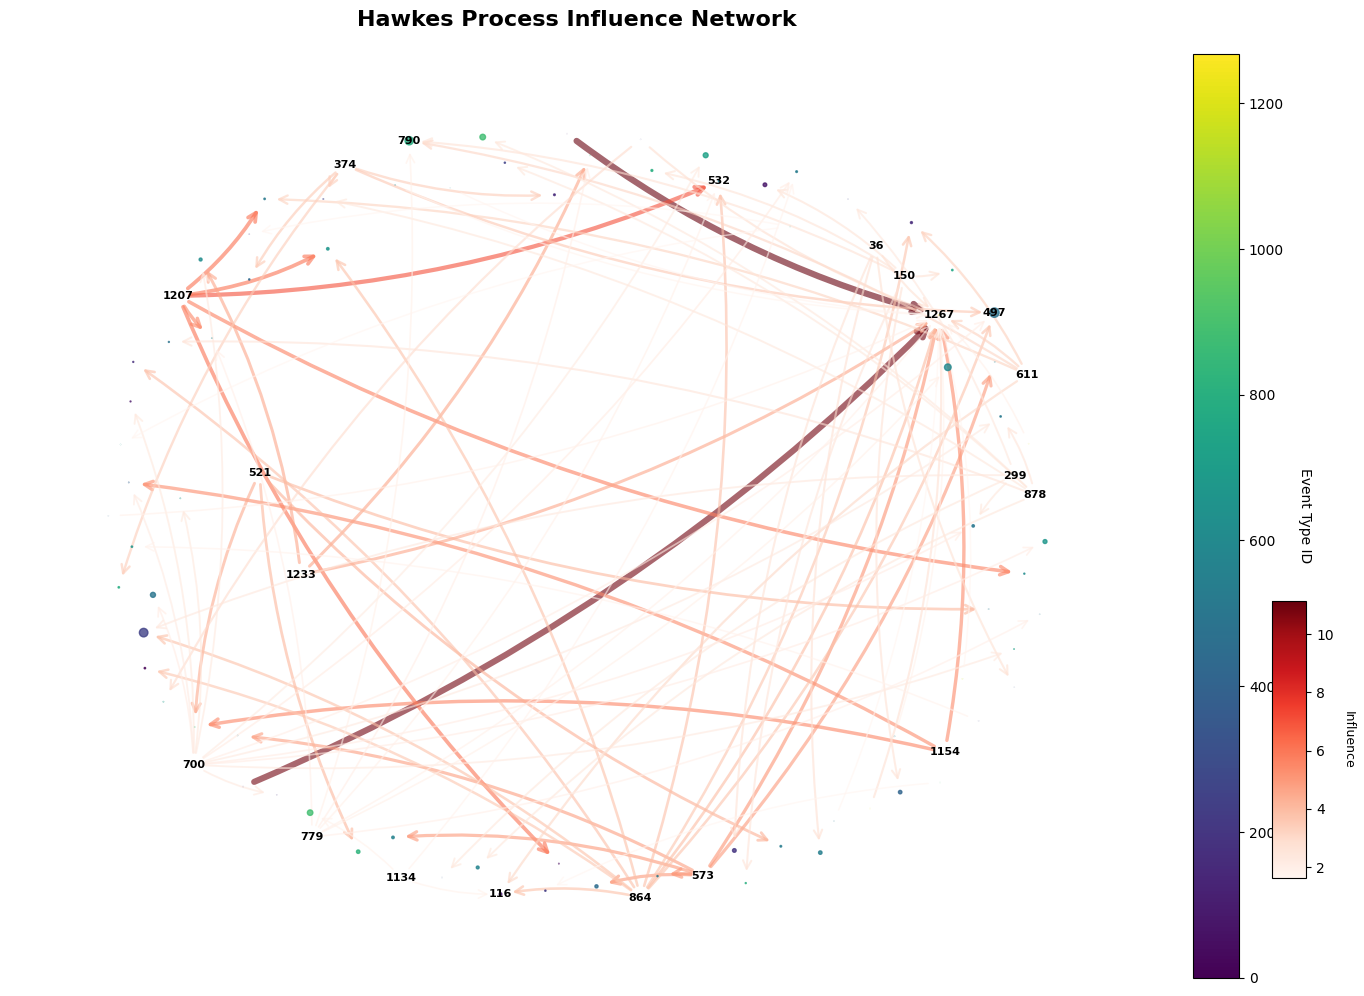

In [24]:
def plot_influence_network(
    influence_matrix, mu, top_k=50, min_influence=0.01, title="Hawkes Process Influence Network"
):
    """
    Plot a network graph showing the strongest influences between event types.

    Args:
        influence_matrix: (D, D) tensor of influences
        mu: (D,) tensor of baseline intensities
        top_k: Number of top edges to show
        min_influence: Minimum influence threshold
    """
    D = influence_matrix.shape[0]

    # Find top-k strongest influences
    inf_flat = influence_matrix.flatten()
    top_indices = torch.argsort(inf_flat, descending=True)[:top_k]

    # Create directed graph
    G = nx.DiGraph()

    # Add edges with influence values
    edge_weights = []
    for idx in top_indices:
        i = idx // D  # receiver
        j = idx % D  # trigger
        influence = influence_matrix[i, j].item()

        if influence >= min_influence and i != j:  # Avoid self-loops
            G.add_edge(j.item(), i.item(), weight=influence)
            edge_weights.append(influence)

    if len(G.edges()) == 0:
        print("No edges to display with current thresholds")
        return

    # Node sizes based on baseline intensity
    node_sizes = []
    for node in G.nodes():
        node_sizes.append(mu[node].item() * 100)  # Scale for visibility

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12), dpi=100)

    # Use spring layout for nice spacing
    pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G, pos, node_size=node_sizes, node_color=list(G.nodes()), cmap="viridis", alpha=0.8, ax=ax
    )

    # Draw edges with varying thickness and color based on influence
    edge_weights_normalized = np.array(edge_weights)
    edge_widths = 0.5 + 4 * (edge_weights_normalized / edge_weights_normalized.max())

    edges = nx.draw_networkx_edges(
        G,
        pos,
        width=edge_widths,
        alpha=0.6,
        edge_color=edge_weights,
        edge_cmap=plt.cm.Reds,
        edge_vmin=min(edge_weights),
        edge_vmax=max(edge_weights),
        arrows=True,
        arrowsize=15,
        arrowstyle="->",
        connectionstyle="arc3,rad=0.1",
        ax=ax,
    )

    # Add labels for a subset of high-degree nodes
    degrees = dict(G.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:20]
    labels = {node: f"{node}" for node in top_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight="bold", ax=ax)

    # Add colorbars
    sm_nodes = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=D))
    sm_nodes.set_array([])
    cbar_nodes = plt.colorbar(sm_nodes, ax=ax, fraction=0.046, pad=0.04)
    cbar_nodes.set_label("Event Type ID", rotation=270, labelpad=20)

    # Create a second colorbar for edge weights
    sm_edges = plt.cm.ScalarMappable(
        cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    )
    sm_edges.set_array([])
    # Position second colorbar
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    axins = inset_axes(
        ax, width="3%", height="30%", loc="lower right", bbox_to_anchor=(0.15, 0.1, 1, 1), bbox_transform=ax.transAxes
    )
    cbar_edges = plt.colorbar(sm_edges, cax=axins)
    cbar_edges.set_label("Influence", rotation=270, labelpad=15, fontsize=9)

    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)
    ax.axis("off")

    # Add legend
    legend_elements = [
        mpatches.Patch(color="none", label="Nodes: Event types (size ∝ baseline μ)"),
        mpatches.Patch(color="none", label=f"Edges: Top {len(G.edges())} influences (width ∝ strength)"),
        mpatches.Patch(color="none", label=f"Time horizon: {time_horizon * 80:.1f} years"),
    ]
    ax.legend(handles=legend_elements, loc="upper left", fontsize=10, framealpha=0.9)

    plt.tight_layout()
    return fig, G


fig, G = plot_influence_network(influence_matrix, mu, top_k=100, min_influence=0.005)
plt.savefig("hawkes_influence_network.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nNetwork Statistics:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Avg in-degree: {sum(d for n, d in G.in_degree()) / G.number_of_nodes():.2f}")
print(f"  Avg out-degree: {sum(d for n, d in G.out_degree()) / G.number_of_nodes():.2f}")

## 2. Network Graph of Top Influences

Show the strongest influence relationships as a directed graph.

In [ ]:
# Compute influence matrix over a realistic time horizon (e.g., 10 years out of 80)
time_horizon = 10 / 80  # 10 years normalized
influence_matrix = alpha * (1 - torch.exp(-beta * time_horizon))

print(f"Influence matrix shape: {influence_matrix.shape}")
print(f"Max influence: {influence_matrix.max().item():.4f}")
print(f"Mean influence: {influence_matrix.mean().item():.6f}")
print(f"Baseline intensity (mu) range: [{mu.min().item():.4f}, {mu.max().item():.4f}]")

## 1. Compute Influence Matrix

The influence of event type j on event type i over a time horizon T is:
$$\text{Influence}_{i,j}(T) = \alpha_{i,j} \cdot (1 - e^{-\beta_{i,j} \cdot T})$$

This represents the cumulative effect one event has on triggering another.